In [1]:
import pandas as pd
import numpy as np

from pyincore import IncoreClient
from pyincore.analyses.socialvulnerability import SocialVulnerability
from pyincore_data.censusutil import CensusUtil
from pyincore import Dataset

In [2]:
client = IncoreClient()

Enter username:  zacbaker
Enter password:  ········


Connection successful to IN-CORE services. pyIncore version detected: 1.14.0


In [3]:
state = "florida"
county = "lee"
year = 2022

In [4]:
# get fips code to use fetch census data
fips = CensusUtil.get_fips_by_state_county(state=state, county=county)
state_code = fips[:2]
county_code = fips[2:]
fips

'12071'

In [5]:
def demographic_factors(state_number, county_number, year, geo_type="tract:*"):

    api_json_1, df_1, ds_1 = CensusUtil.get_census_data(state=state_code, county=county_code, year=year,
                                                              data_source="acs/acs5",
                                                              columns="GEO_ID,B03002_001E,B03002_003E",
                                                              geo_type=geo_type)
    df_1["factor_white_nonHispanic"] = df_1[["B03002_001E","B03002_003E"]].astype(int).apply(lambda row: row["B03002_003E"]/row["B03002_001E"] if row["B03002_001E"] != 0 else 999, axis = 1)

    api_json_2, df_2, ds_2 = CensusUtil.get_census_data(state=state_code, county=county_code, year=year,
                                                  data_source="acs/acs5",
                                                  columns="B25003_001E,B25003_002E",
                                                  geo_type=geo_type)
    df_2["factor_owner_occupied"] = df_2.astype(int).apply(lambda row: row["B25003_002E"]/row["B25003_001E"] if row["B25003_001E"] != 0 else 999, axis = 1)
    
    api_json_3, df_3, ds_3 = CensusUtil.get_census_data(state=state_code, 
                                         county=county_code, 
                                         year=year,
                                         data_source="acs/acs5",
                                         columns="B17021_001E,B17021_002E",
                                         geo_type=geo_type)
    df_3["factor_earning_higher_than_national_poverty_rate"] = df_3.astype(int).apply(lambda row: 1-row["B17021_002E"]/row["B17021_001E"] if row["B17021_001E"] != 0 else 999, axis = 1)
    
    api_json_4, df_4, ds_4 = CensusUtil.get_census_data(state=state_code, 
                                         county=county_code, 
                                         year=year,
                                         data_source="acs/acs5", 
                                         columns="B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E,B15003_021E,B15003_022E,B15003_023E,B15003_024E,B15003_025E",
                                         geo_type=geo_type)
    df_4["factor_over_25_with_high_school_diploma_or_higher"] = df_4.astype(int).apply(lambda row: (row["B15003_017E"] 
                                                                                                    + row["B15003_018E"] 
                                                                                                    + row["B15003_019E"] 
                                                                                                    + row["B15003_020E"] 
                                                                                                    + row["B15003_021E"] 
                                                                                                    + row["B15003_022E"] 
                                                                                                    + row["B15003_023E"] 
                                                                                                    + row["B15003_024E"] 
                                                                                                    + row["B15003_025E"])/row["B15003_001E"] if row["B15003_001E"] != 0 else 999, axis = 1)

    if geo_type == 'tract:*':
        api_json_5, df_5, ds_5 = CensusUtil.get_census_data(state=state_code, 
                                             county=county_code, 
                                             year=year,
                                             data_source="acs/acs5",
                                             columns="B18101_001E,B18101_011E,B18101_014E,B18101_030E,B18101_033E",
                                             geo_type=geo_type)
        df_5["factor_without_disability_age_18_to_65"] = df_5.astype(int).apply(lambda row: (row["B18101_011E"] + row["B18101_014E"] + row["B18101_030E"] + row["B18101_033E"])/row["B18101_001E"] if row["B18101_001E"] != 0 else 999, axis = 1)
    
    elif geo_type == 'block%20group:*':
        api_json_5, df_5, ds_5 = CensusUtil.get_census_data(state=state_code, 
                                             county=county_code, 
                                             year=year,
                                             data_source="acs/acs5",
                                             columns="B01003_001E,C21007_006E,C21007_009E,C21007_013E,C21007_016E",
                                             geo_type=geo_type)

        df_5['factor_without_disability_age_18_to_65'] = df_5.astype(int).apply(lambda row: (row['C21007_006E']+
                                                                                 row['C21007_006E']+
                                                                                 row['C21007_009E']+
                                                                                 row['C21007_013E'])
                                                                                /row['C21007_016E'] if row["C21007_016E"] != 0 else 999, axis = 1)

    df_t = pd.concat([df_1[["GEO_ID","factor_white_nonHispanic"]],
                      df_2["factor_owner_occupied"],
                      df_3["factor_earning_higher_than_national_poverty_rate"], 
                      df_4["factor_over_25_with_high_school_diploma_or_higher"],
                      df_5["factor_without_disability_age_18_to_65"]], 
                     axis=1, join='inner')
    
    # extract FIPS from geo id
    df_t["FIPS"] = df_t.apply(lambda row: row["GEO_ID"].split("US")[1], axis = 1)
        
    return df_t

In [6]:
def national_ave_values (year, data_source="acs/acs5"):
    api_json_1, nav1, ds_1 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B03002_001E,B03002_003E",geo_type=None)
    nav1 = nav1.astype(int)
    nav1_avg ={"feature": "NAV-1: White, nonHispanic", 
                "average": nav1['B03002_003E'].sum()/ nav1['B03002_001E'].sum()}

    api_json_2, nav2, ds_2 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B25003_001E,B25003_002E",geo_type=None)
    nav2 = nav2.astype(int)
    nav2_avg = {"feature": "NAV-2: Home Owners", 
                "average": nav2['B25003_002E'].sum()/nav2['B25003_001E'].sum()}

    api_json_3, nav3, ds_3 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B17021_001E,B17021_002E",geo_type=None)
    nav3 = nav3.astype(int)
    nav3_avg = {"feature": "NAV-3: earning higher than national poverty rate", 
                "average": 1-nav3['B17021_002E'].sum()/nav3['B17021_001E'].sum()}

    api_json_4, nav4, ds_4 = CensusUtil.get_census_data(state="*", 
                                         county=None, 
                                         year=year,
                                         data_source="acs/acs5",
                                         columns="B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E,B15003_021E,B15003_022E,B15003_023E,B15003_024E,B15003_025E",
                                         geo_type=None)
    nav4 = nav4.astype(int)
    nav4['temp'] = nav4.apply(lambda row: row['B15003_017E']+row['B15003_018E']+row['B15003_019E']+
                              row['B15003_020E']+row['B15003_021E']+row['B15003_022E']+row['B15003_023E']+
                              row['B15003_024E']+row['B15003_025E'], axis = 1)
    nav4_avg = {"feature": 'NAV-4: over 25 with high school diploma or higher', 
                "average": nav4['temp'].sum()/nav4['B15003_001E'].sum()}

    api_json_5, nav5, ds_5 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B18101_001E,B18101_011E,B18101_014E,B18101_030E,B18101_033E",
                                         geo_type=None)
    nav5 = nav5.astype(int)
    nav5['temp'] = nav5.apply(lambda row: row['B18101_011E']+row['B18101_014E']+row['B18101_030E']+row['B18101_033E'], axis = 1)
    nav5_avg = {"feature": 'NAV-5: without disability age 18 to 65', 
                "average": nav5["temp"].sum()/nav5["B18101_001E"].sum()}
    
    navs = [nav1_avg, nav2_avg, nav3_avg, nav4_avg, nav5_avg]
    
    return navs

In [7]:
navs = national_ave_values(year=2022)
national_vulnerability_feature_averages = Dataset.from_csv_data(navs, name="national_vulnerability_feature_averages.csv",
                                                                 data_type="incore:socialVulnerabilityFeatureAverages")

csv saved as api_20240531-094700.csv
csv saved as api_20240531-094701.csv
csv saved as api_20240531-094702.csv
csv saved as api_20240531-094704.csv
csv saved as api_20240531-094705.csv


In [8]:
geo_type = "tract:*"
social_vunlnerability_dem_factors_df = demographic_factors(state_code, county_code, year=2022, geo_type=geo_type)
social_vunlnerability_dem_factors = Dataset.from_dataframe(social_vunlnerability_dem_factors_df, 
                                                           name="social_vunlnerability_dem_factors",
                                                           data_type="incore:socialVulnerabilityDemFactors")

csv saved as api_20240531-094706.csv
csv saved as api_20240531-094707.csv
csv saved as api_20240531-094709.csv
csv saved as api_20240531-094710.csv
csv saved as api_20240531-094712.csv


In [9]:
# Configure pyincore access and the analysis with the information above

client = IncoreClient()
social_vulnerability = SocialVulnerability(client)

social_vulnerability.set_parameter("result_name", "social_vulnerabilty")
social_vulnerability.set_input_dataset("national_vulnerability_feature_averages", national_vulnerability_feature_averages)
social_vulnerability.set_input_dataset("social_vulnerability_demographic_factors", social_vunlnerability_dem_factors)

Connection successful to IN-CORE services. pyIncore version detected: 1.14.0


True

In [10]:
# Run social vulnerability damage analysis
result = social_vulnerability.run_analysis()

In [11]:
# Retrieve result dataset
result = social_vulnerability.get_output_dataset("sv_result")

# Convert dataset to Pandas DataFrame
sv_df = result.get_dataframe_from_csv()
sv_df.head()

,GEO_ID,factor_white_nonHispanic,factor_owner_occupied,factor_earning_higher_than_national_poverty_rate,factor_over_25_with_high_school_diploma_or_higher,factor_without_disability_age_18_to_65,FIPS,R1,R2,R3,R4,R5,SVS,zone
0,1400000US12071000303,0.304398,0.622924,0.794084,0.671244,0.546007,12071000303,0.522188,0.960599,0.910952,0.753846,0.996831,0.828883,Medium to High Vulnerable (zone4)
1,1400000US12071000304,0.721519,0.324147,0.931284,0.923497,0.677517,12071000304,1.237750,0.499861,1.068345,1.037141,1.236924,1.016004,Medium Vulnerable (zone3)
2,1400000US12071000305,0.080253,0.329201,0.800422,0.691824,0.591341,12071000305,0.137673,0.507655,0.918224,0.776958,1.079596,0.684021,High Vulnerable (zone5)
3,1400000US12071000306,0.203542,0.294118,0.759348,0.573745,0.651392,12071000306,0.349172,0.453553,0.871104,0.644349,1.189229,0.701481,High Vulnerable (zone5)
4,1400000US12071000401,0.344257,0.651111,0.899662,0.656484,0.588814,12071000401,0.590565,1.004066,1.032069,0.737270,1.074981,0.887790,Medium to High Vulnerable (zone4)


In [12]:
# plotting the social vulnerability data in lee county

In [62]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import pandas as pd 
import contextily as ctx 
import geopandas as gpd 
import seaborn as sns
import os 
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [14]:
# load openfema owners data
owner_data = gpd.read_file(r"../data/HousingAssistanceOwners.csv")
owner_data.head()

,disasterNumber,state,county,city,zipCode,validRegistrations,averageFemaInspectedDamage,totalInspected,totalDamage,noFemaInspectedDamage,...,totalApprovedIhpAmount,repairReplaceAmount,rentalAmount,otherNeedsAmount,approvedBetween1And10000,approvedBetween10001And25000,approvedBetween25001AndMax,totalMaxGrants,id,geometry
0,1439,TX,Aransas (County),ARANSAS PASS,78335,4,1345.01,3,5380.02,0,...,5915.91,3573.02,970,1372.89,3,0,0,0,24148449-87c6-4f58-8d14-e469c3f0581a,None
1,1439,TX,Aransas (County),ARANSAS PASS,78336,68,3082.82,63,209632.06,4,...,180717.57,131097.36,23946,25674.21,27,26,1,0,03688be7-62df-43e2-b2b3-0eefc8516644,None
2,1439,TX,Aransas (County),FULTON,78358,20,4722.34,18,94446.72,0,...,94240.88,58754.7,6784,28702.18,3,11,3,0,fa08ef35-8563-49bb-bb74-2fe8d64f4d77,None
3,1439,TX,Aransas (County),FULTON,78381,1,2578.3,1,2578.3,0,...,3304.3,1407.96,726,1170.34,1,0,0,0,fc5e65b1-522d-48e7-b3e2-69eb560caf00,None
4,1439,TX,Aransas (County),ROCKPORT,78331,1,0,0,0,0,...,0,0,0,0,0,0,0,0,37a8634d-3c69-44a3-8414-c281e22ff561,None


In [15]:
disaster_data = gpd.read_file(r"../data/DisasterDeclarationsSummaries.csv")
disaster_data.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,...,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,lastIAFilingDate,lastRefresh,hash,id,geometry
0,FM-5464-RI,5464,RI,FM,2023-04-14T00:00:00.000Z,2023,Fire,QUEENS RIVER FIRE,0,0,...,44,9,99009,"Washington (County)(in (P)MSA 5520,6480)",23042,,2023-05-22T03:41:22.800Z,1111d4d4a33f8a6e4d383ac5bd0e60b9bf142da0,9b9a9d9c-8b03-4049-9b16-a3c0d581556c,None
1,FM-5463-KS,5463,KS,FM,2023-04-13T00:00:00.000Z,2023,Fire,HADDAM FIRE,0,0,...,20,201,99201,Washington (County),23038,,2023-05-22T03:41:22.800Z,78dd55a181f146622eb65835b5d794689d1ea7f2,57d936ce-a0d7-412a-9d78-18aee530c146,None
2,DR-4731-CO,4731,CO,DR,2023-08-25T00:00:00.000Z,2023,Flood,"SEVERE STORMS, FLOODING, AND TORNADOES",0,0,...,8,9,99009,Baca (County),23081,,2023-10-02T19:21:20.859Z,44d903d3d79b5295f58aefdd35682a8d3011644d,fe1befa2-d7ac-4400-b430-36bf30ac9a15,None
3,DR-4731-CO,4731,CO,DR,2023-08-25T00:00:00.000Z,2023,Flood,"SEVERE STORMS, FLOODING, AND TORNADOES",0,0,...,8,61,99061,Kiowa (County),23081,,2023-10-02T19:21:20.859Z,ecfd4777766336e18a46d1eb231fc25922f8b014,880f5941-94fb-4c00-afb8-2f1e32fe1b5b,None
4,DR-4731-CO,4731,CO,DR,2023-08-25T00:00:00.000Z,2023,Flood,"SEVERE STORMS, FLOODING, AND TORNADOES",0,0,...,8,99,99099,Prowers (County),23081,,2023-10-02T19:21:20.859Z,90ab966409613986143ee242870748e8d19aa525,875a66ca-6234-423a-9e92-3626484e11d6,None


In [16]:
# process the gini index for Lee County
gini_data = gpd.read_file(r"../data/gini.csv")
gini_dict = dict()
for column in gini_data[1:-1]: 
    if "Error" in column: continue
    tract = column.split(";")[0].split(" ")
    if tract[0] != "Census": continue
    tract = tract[2]
    if not "." in tract: tract = tract + ".00"
    tract = "".join(tract.split("."))
    while len(tract) < 6: tract = "0" + tract
    gini_dict[tract] = gini_data[column][0]

In [201]:
# load shape file for Lee County, Florida which has the intersection of zip codes and census tracts

joint_tracts_zip = gpd.read_file(r"../lee_county_zip_tract_intersection.shp")
joint_tracts_zip = joint_tracts_zip.to_crs("EPSG:4326")

num_rows = len(joint_tracts_zip)
joint_tracts_zip["sv_zone"] = np.zeros(num_rows)
joint_tracts_zip["percent_aid_approved"] = np.zeros(num_rows)
joint_tracts_zip["percent_people_approved"] = np.zeros(num_rows)
joint_tracts_zip["average_damage"] = np.zeros(num_rows)
joint_tracts_zip["percent_eligible_approved"] = np.zeros(num_rows)
joint_tracts_zip["eligible"] = np.zeros(num_rows)
joint_tracts_zip["applicants"] = np.zeros(num_rows)

for ind, row in joint_tracts_zip.iterrows():
    geo_index = sv_df["GEO_ID"].tolist().index(row["GEOIDFQ"])
    joint_tracts_zip.loc[ind, "sv_zone"] = int(sv_df["zone"][geo_index][-2:-1])
    
    indicies = np.where(owner_data["zipCode"] == row["ZCTA5CE10"])[0]
    
    totalDam = totalApp = totalInsp = totalAppr = totalDama = totalElig = 0
    
    for i in indicies:
        disasterNumber = owner_data["disasterNumber"][i]
        disaster_index = np.where(disaster_data["disasterNumber"] == disasterNumber)[0]
        
        if disaster_index.size == 0: continue
        disasterNumber = disaster_index[0]
        if int(disaster_data["fyDeclared"][disasterNumber]) < 2010: continue
        
        totalDam += float(owner_data["totalDamage"][i])
        totalApp += float(owner_data["totalApprovedIhpAmount"][i])
        totalAppr += int(owner_data["approvedForFemaAssistance"][i])
        totalInsp += int(owner_data["totalInspected"][i])
        totalDama += float(owner_data["averageFemaInspectedDamage"][i])
        totalElig += int(owner_data["validRegistrations"][i])
        
    joint_tracts_zip.loc[ind, "percent_aid_approved"] = float(totalApp) / float(totalDam) if totalDam != 0 else 3.1419526535
    joint_tracts_zip.loc[ind, "percent_people_approved"] = totalAppr / totalInsp if totalInsp != 0 else 3.1419526535
    joint_tracts_zip.loc[ind, "average_damage"] = totalDama / len(indicies) if len(indicies) != 0 else 0
    joint_tracts_zip.loc[ind, "percent_eligible_approved"] = totalAppr/totalElig if totalElig != 0 else 3.1419526535
    joint_tracts_zip.loc[ind, "eligible"] = totalElig
    joint_tracts_zip.loc[ind, "applicants"] = totalInsp

In [223]:
gini = []

for i in range(534):
    if gini_dict[joint_tracts_zip["TRACTCE"][i]] == "-": gini_dict[joint_tracts_zip["TRACTCE"][i]] = 0.44
    gini.append(float(gini_dict[joint_tracts_zip["TRACTCE"][i]]))

joint_tracts_zip["gini_value"] = gini

In [233]:
filtered_df = joint_tracts_zip[joint_tracts_zip['percent_aid_approved'] != 3.1419526535]
filtered_df = joint_tracts_zip[joint_tracts_zip['percent_people_approved'] != 3.1419526535]
filtered_df = joint_tracts_zip[joint_tracts_zip['percent_eligible_approved'] != 3.1419526535]
filtered_df = filtered_df[filtered_df['average_damage'] > 1500]

filtered_df.to_csv('filtered_data.csv', index=False)

In [225]:
from scipy.stats import pearsonr

# run correlation on sv_zone and percent_aid_approved, percent_people_approved, average_damage, gini_value, percent_eligible_approved, applicants, eligible
r_value, p_value = pearsonr(filtered_df["percent_aid_approved"], filtered_df["eligible"])

print(f"Pearson correlation coefficient: {r_value}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: -0.4325488082678881
P-value: 1.7955437745463857e-07


In [232]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = filtered_df[['sv_zone', 'gini_value', 'average_damage', 'applicants', 'eligible']]
Y = filtered_df['percent_people_approved']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")
print(f"Mean squared error: {mse}")
print(f"R-squared: {r2}")

Coefficients: [ 2.90254402e-02  1.39304391e-01 -4.31879457e-06 -9.93079151e-05
  5.05221156e-05]
Intercept: 0.918778817966823
Mean squared error: 0.001543102832607576
R-squared: 0.7662701922254262


In [98]:
# define different coloring functions for the plot of Lee County
def zone_to_color(value):
    index = np.where(joint_tracts_zip['sv_zone'] == value)[0]
    # if joint_tracts_zip["percent_aid_approved"][index[0]] == 0: 
    #     return "black"
    if value == "1": return "green"
    elif value == "2": return "cyan"
    elif value == "3": return "yellow"
    elif value == "4": return "orange"
    else: return "red"

def damage_to_color(value):
    if value == 0: return "purple"
    if float(value) > 1: return "green"
    elif float(value) > 0.66: return "yellow"
    elif float(value) > 0.33: return "orange"
    else: return "red"

def avgdamage_to_color(value):
    if value == 0: return "purple"
    if float(value) > 4000: return "red"
    elif float(value) > 1500: return "orange"
    elif float(value) > 750: return "yellow"
    elif float(value) > 500: return "cyan"
    else: return "green"

def gini_to_color(value):
    if value == 0: return "purple"
    if float(value) > 0.625: return "green"
    elif float(value) > 0.5: return "yellow"
    elif float(value) > 0.375: return "orange"
    else: return "red"

sv_zone_colors = joint_tracts_zip['sv_zone'].apply(zone_to_color)
damage_colors = joint_tracts_zip['percent_aid_approved'].apply(damage_to_color)
people_colors = joint_tracts_zip['percent_people_approved'].apply(people_to_color)
gini_colors = joint_tracts_zip['gini_value'].apply(gini_to_color)
damage_colors = joint_tracts_zip['average_damage'].apply(avgdamage_to_color)

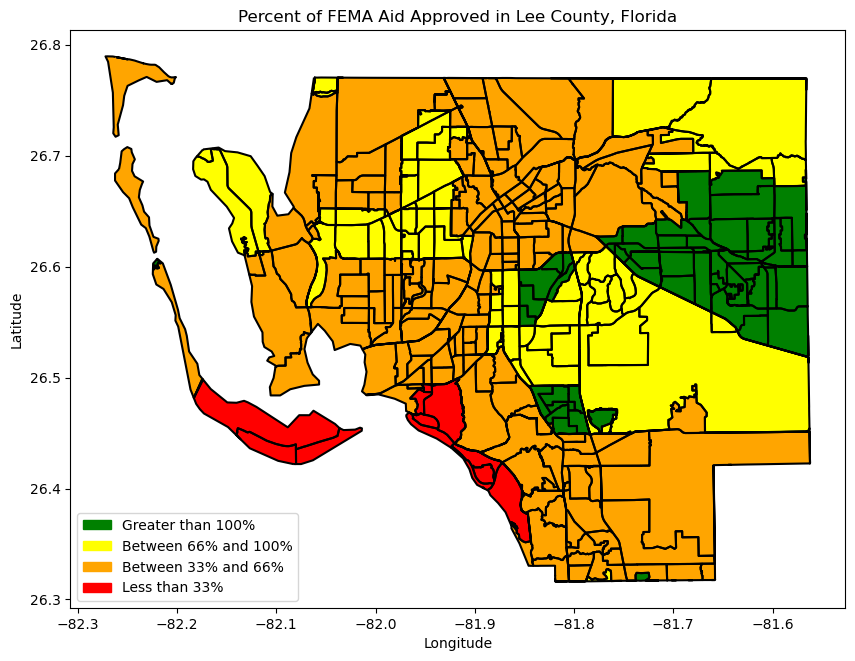

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Percent of FEMA Aid Approved in Lee County, Florida")

joint_tracts_zip.boundary.plot(ax=ax, edgecolor='black')
joint_tracts_zip.plot(ax=ax, color=damage_colors)

zone1 = mpatches.Patch(color='green', label='Greater than 100%')
zone3 = mpatches.Patch(color='yellow', label='Between 66% and 100%')
zone4 = mpatches.Patch(color='orange', label='Between 33% and 66%')
zone5 = mpatches.Patch(color='red', label='Less than 33%')
plt.legend(handles=[zone1, zone3, zone4, zone5], loc="lower left")
plt.show()

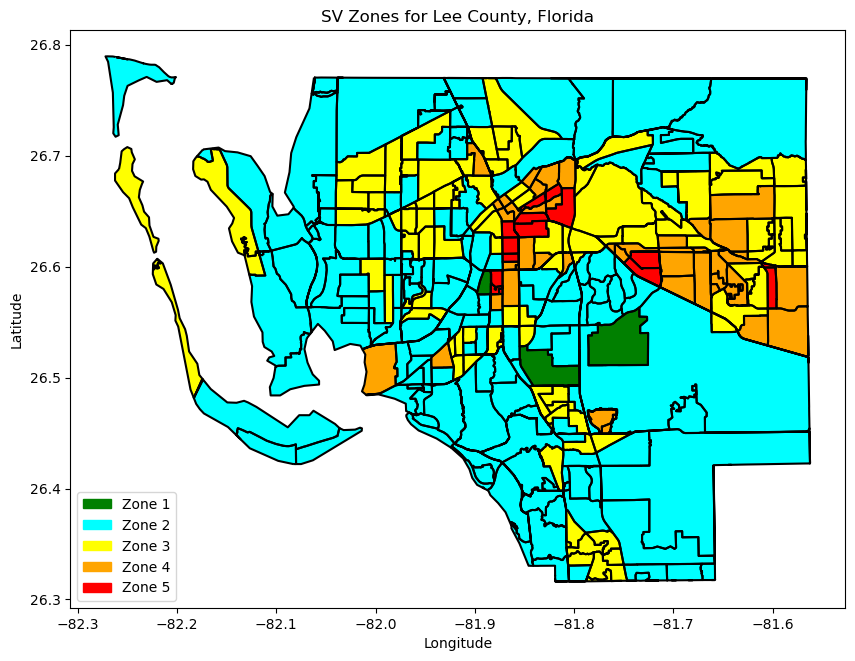

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("SV Zones for Lee County, Florida")

joint_tracts_zip.boundary.plot(ax=ax, edgecolor='black')
joint_tracts_zip.plot(ax=ax, color=sv_zone_colors)

zone1 = mpatches.Patch(color='green', label='Zone 1')
zone2 = mpatches.Patch(color='cyan', label='Zone 2')
zone3 = mpatches.Patch(color='yellow', label='Zone 3')
zone4 = mpatches.Patch(color='orange', label='Zone 4')
zone5 = mpatches.Patch(color='red', label='Zone 5')
plt.legend(handles=[zone1, zone2, zone3, zone4, zone5], loc="lower left")
plt.show()

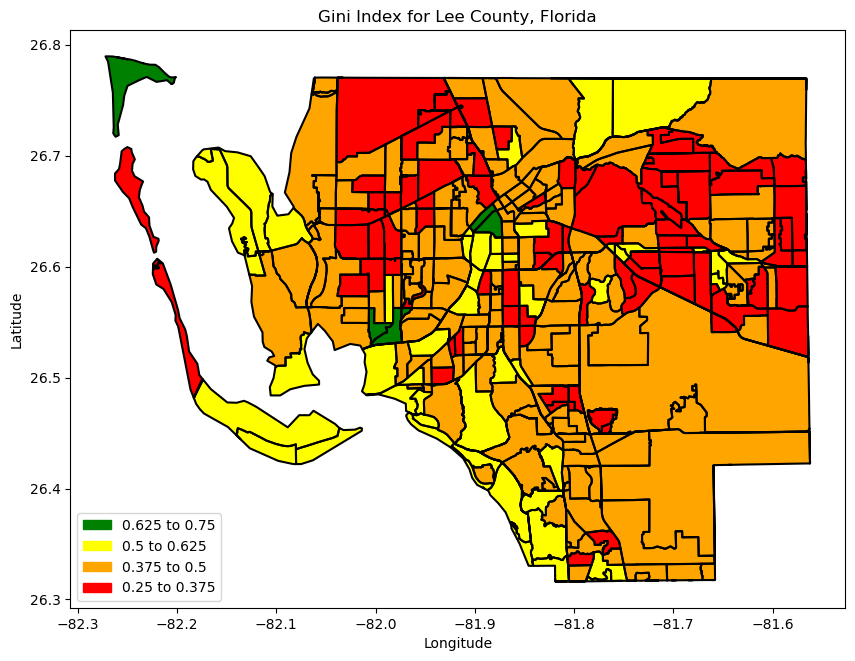

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Gini Index for Lee County, Florida")

joint_tracts_zip.boundary.plot(ax=ax, edgecolor='black')
joint_tracts_zip.plot(ax=ax, color=gini_colors)

zone1 = mpatches.Patch(label='0.625 to 0.75', color='green')
zone3 = mpatches.Patch(label='0.5 to 0.625', color='yellow')
zone4 = mpatches.Patch(label='0.375 to 0.5', color='orange')
zone5 = mpatches.Patch(label='0.25 to 0.375', color='red')
plt.legend(handles=[zone1, zone3, zone4, zone5], loc="lower left")
plt.show()

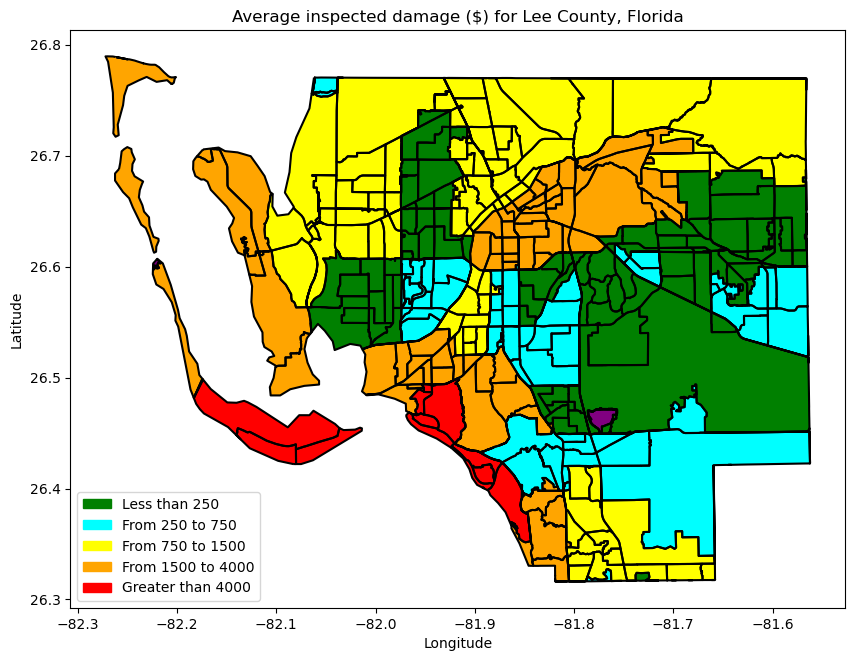

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Average inspected damage ($) for Lee County, Florida")

joint_tracts_zip.boundary.plot(ax=ax, edgecolor='black')
joint_tracts_zip.plot(ax=ax, color=damage_colors)

zone1 = mpatches.Patch(label='Less than 250', color='green')
zone2 = mpatches.Patch(label='From 250 to 750', color='cyan')
zone3 = mpatches.Patch(label='From 750 to 1500', color='yellow')
zone4 = mpatches.Patch(label='From 1500 to 4000', color='orange')
zone5 = mpatches.Patch(label='Greater than 4000', color='red')
plt.legend(handles=[zone1, zone2, zone3, zone4, zone5], loc="lower left")
plt.show()